In [72]:
from PlainNet import FlairNPYSliceDataset, compute_pos_weight_from_dataset

path_data = "../01_data/04_flair_preproc_slices/"
train_ds = FlairNPYSliceDataset(root_dir=path_data, split="train")
val_ds   = FlairNPYSliceDataset(root_dir=path_data, split="val")
test_ds  = FlairNPYSliceDataset(root_dir=path_data, split="test")

print(len(train_ds), len(val_ds), len(test_ds))

# pos_weight 계산
print("Train pos_weight:", compute_pos_weight_from_dataset(train_ds))

# dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)
batch = next(iter(train_loader))
print(batch["image"].shape, batch["label"].shape)
print(batch["subject_id"])         # e.g. ['subject1', 'subject3', ...]
print(batch["slice_idx"])          # e.g. [12, 45, 3, 88, ...]
print(batch["label"])
# torch.Size([8,1,672,672]) torch.Size([8])

42435 9030 9048
Train pos_weight: tensor(48.4580)
torch.Size([8, 1, 672, 672]) torch.Size([8])
['BP00518_P16950', 'HP00094_P01876', 'HP00055_P05753', 'HP00421_P07283', 'HP00722_P07404', 'HP00334_P04870', 'HP00141_P01647', 'HP00770_P05887']
tensor([ 7, 20,  5, 16, 21, 20,  1, 19])
tensor([0., 0., 0., 0., 0., 0., 0., 0.])


In [138]:
import numpy as np
batch = next(iter(train_loader))
print(batch["image"].shape, batch["label"].shape)
print(batch["subject_id"])         # e.g. ['subject1', 'subject3', ...]
print(batch["slice_idx"])          # e.g. [12, 45, 3, 88, ...]
print(batch["label"])

idx = np.arange(8)[batch["label"] == 1]
print(np.array(batch["subject_id"])[idx])
print(batch['slice_idx'][idx])

torch.Size([8, 1, 672, 672]) torch.Size([8])
['HP00209_P02691', 'HP00729_P04570', 'HP00130_P04420', 'BP00185_P13256', 'BP00376_P11730', 'BP00418_P12627', 'BP00139_P12079', 'HP00878_P07632']
tensor([12, 13,  9,  7, 22, 22,  2,  4])
tensor([0., 1., 0., 0., 0., 0., 0., 0.])
['HP00729_P04570']
tensor([13])


In [1]:
import torch
from torchsummary import summary
from PlainNet.models.plainnet import PlainNet

# 모델 생성
model = PlainNet(backbone="resnet18", in_channels=1, pretrained=False)

# GPU에 올리기 (CUDA 있으면)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# summary 출력
summary(model, input_size=(1, 672, 672))  # (채널, H, W)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 336, 336]           3,136
       BatchNorm2d-2         [-1, 64, 336, 336]             128
              ReLU-3         [-1, 64, 336, 336]               0
         MaxPool2d-4         [-1, 64, 168, 168]               0
            Conv2d-5         [-1, 64, 168, 168]          36,864
       BatchNorm2d-6         [-1, 64, 168, 168]             128
              ReLU-7         [-1, 64, 168, 168]               0
            Conv2d-8         [-1, 64, 168, 168]          36,864
       BatchNorm2d-9         [-1, 64, 168, 168]             128
             ReLU-10         [-1, 64, 168, 168]               0
       BasicBlock-11         [-1, 64, 168, 168]               0
           Conv2d-12         [-1, 64, 168, 168]          36,864
      BatchNorm2d-13         [-1, 64, 168, 168]             128
             ReLU-14         [-1, 64, 1

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def plot_curves(metrics_file, outdir):
    df = pd.read_csv(metrics_file)

    # 1) Loss plot
    plt.figure()
    plt.plot(df["epoch"], df["train_loss"], label="Train Loss")
    plt.plot(df["epoch"], df["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.savefig(os.path.join(outdir, "loss_curve.png"))
    plt.close()

    # 2) Accuracy plot
    plt.figure()
    plt.plot(df["epoch"], df["train_acc"], label="Train Acc")
    plt.plot(df["epoch"], df["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.savefig(os.path.join(outdir, "accuracy_curve.png"))
    plt.close()

    # 3) F1 score plot
    plt.figure()
    plt.plot(df["epoch"], df["train_f1"], label="Train F1")
    plt.plot(df["epoch"], df["val_f1"], label="Val F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.title("Training and Validation F1 Score")
    plt.savefig(os.path.join(outdir, "f1_curve.png"))
    plt.close()

path = "/zdisk/users/ext_user_03/01_yschoi/project_01_FVH_detection/model_02_ReportGuideNet/PlainNet/runs/swin_transformer_cleanImg04"
metrics_file = f'{path}/metrics.csv'
outdir = path
plot_curves(metrics_file, outdir)

In [4]:
import h5py

h5_path = "/zdisk/users/ext_user_03/01_yschoi/project_01_FVH_detection/01_data/06_flair_preproc_slices_v02_compress_h5/flair_slice_dataset.h5"
h5 = h5py.File(h5_path, "r")

In [1]:
import torch
from swin_transformer_pytorch import SwinTransformer

net = SwinTransformer(
    hidden_dim=96,
    layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24),
    channels=3,
    num_classes=3,
    head_dim=32,
    window_size=7,
    downscaling_factors=(4, 2, 2, 2),
    relative_pos_embedding=True
)
dummy_x = torch.randn(1, 3, 224, 224)
logits = net(dummy_x)  # (1,3)
print(net)
print(logits)

SwinTransformer(
  (stage1): StageModule(
    (patch_partition): PatchMerging(
      (patch_merge): Unfold(kernel_size=4, dilation=1, padding=0, stride=4)
      (linear): Linear(in_features=48, out_features=96, bias=True)
    )
    (layers): ModuleList(
      (0): ModuleList(
        (0): SwinBlock(
          (attention_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): WindowAttention(
                (to_qkv): Linear(in_features=96, out_features=288, bias=False)
                (to_out): Linear(in_features=96, out_features=96, bias=True)
              )
            )
          )
          (mlp_block): Residual(
            (fn): PreNorm(
              (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (fn): FeedForward(
                (net): Sequential(
                  (0): Linear(in_features=96, out_features=384, bias=True)
                  (1): GELU(approximate='none

stage1.layers.0.0.attention_block.fn.fn torch.Size([1, 3, 64, 49, 49])


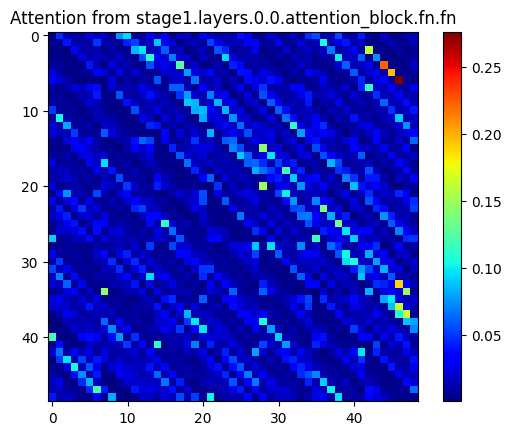

In [3]:
from PlainNet.cam.attention_rollout import AttentionRollout
import matplotlib.pyplot as plt
from swin_transformer_pytorch.swin_transformer import SwinTransformer, WindowAttention  # 네 코드 기준 import
import torch

# 모델 생성 (네 Swin config대로)
net = SwinTransformer(
    hidden_dim=96, layers=(2, 2, 6, 2),
    heads=(3, 6, 12, 24), channels=1,
    num_classes=1, head_dim=32,
    window_size=7, downscaling_factors=(4,2,2,2),
    relative_pos_embedding=True
)

# AttentionRollout 초기화 -> 여기서 monkey-patch 자동 적용됨
rollout = AttentionRollout(net)

# 더미 입력
dummy_x = torch.randn(1, 1, 224, 224)
out = net(dummy_x)

# 각 WindowAttention에 저장된 last_attn 확인
for name, module in net.named_modules():
    if isinstance(module, WindowAttention) and hasattr(module, "last_attn"):
        print(name, module.last_attn.shape)
        attn_map = module.last_attn[0,0]  # batch=0, head=0
        plt.imshow(attn_map[0].numpy(), cmap="jet")
        plt.colorbar()
        plt.title(f"Attention from {name}")
        plt.show()
        break
